### Import python modules 

In [1]:
# 导入模块
import os
os.environ['CUDA_VISIBLE_DEVICES']= "3"

import math
import random
import numpy as np
import apply
import json
from pprint import pprint
import torch
import torch.nn.functional as F

import models, utils, draw, dataset

random_state = 12314
torch.manual_seed(random_state) # cpu
np.random.seed(random_state)    # numpy
random.seed(random_state)       # random and transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    num_GPU = torch.cuda.device_count()
    print(f"可用 GPU 数量: {num_GPU}")
else:
    num_GPU = 1
    
print(f"运行平台: {device}")
root_path = os.path.abspath('.')

figsize = (4,4)

/pscratch/sd/z/zfbi/anaconda/pytimes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


可用 GPU 数量: 1
运行平台: cuda


### Load synthetic geologic models

In [42]:
dataset_name = "seismic_inversion_tpd-regression-6120"
dataset_path = os.path.join("dataset", dataset_name)

samples_train = dataset.read_json(os.path.join(dataset_path, 'samples_train.json'))
samples_valid = dataset.read_json(os.path.join(dataset_path, 'samples_valid.json'))

print(f"训练样本数量: {len(samples_train)}")
print(f"验证样本数量: {len(samples_valid)}")

data_info = np.load(os.path.join(dataset_path, 'summary.npy'), allow_pickle=True).item()
train_well_names = data_info['train_well_names']
well_positions = data_info['well_positions']
image_type = data_info.get('image_type', ['data'])

训练样本数量: 702
验证样本数量: 98


In [44]:
param = dict()

# 数据参数
param['image_type'] = image_type
param['task_mode'] = 'regress'

# 网络种类
param['model_name'] = "SDSAM"
param['sam_checkpoint'] = True
param['model_type'] = "vit_b"
param['transfer'] = "lora"
param['num_lora'] = 1
param['encoder_type'] = 'vit'
param['use_graph'] = False

# 提示引擎
param['mask_threshold'] = 0.0
param['prompt_types'] = []

# 网络架构
param['mask_in_chans'] = 64
param['image_encode_size'] = 512
param['num_multimask_outputs'] = 1
param['mask_decoder_depth'] = 4
param['mask_decoder_heads'] = 8
param['mask_mlp_hidden_dim'] = 2048
param['image_encode_dim'] = 512

# 训练参数
param['epochs'] = 400    # 训练轮数
param['batch_size'] = num_GPU * 16 # 批大小
param['warmup_steps'] = 0
param['num_GPU'] = num_GPU
param['disp_inter'] = 10 # 显示间隔
param['save_inter'] = 10 # 保存间隔
param['test_inter'] = 10

# 学习参数
param['lr'] = 1e-4         # 学习率
param['optimizer_type'] = 'AdamW' # 优化器类型
param['weight_decay'] = 0.0 # 权重衰减
param['gamma'] = 0.5    # 学习率衰减系数
param['lr_decay'] = 10   # 学习率衰减周期
param['decay_type'] = 'ReduceLROnPlateau'

# 损失函数
param['loss_type'] = {'mse': 1.0}

In [45]:
train_data =  utils.build_dataset_regression(param, samples_train, mode='Train', norm=None)

train_sample: dict_keys(['image', 'UID', 'original_size', 'masks', 'labels', 'weights', 'attrs'])


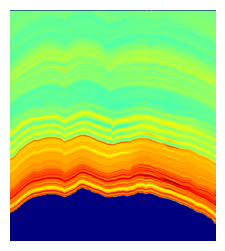

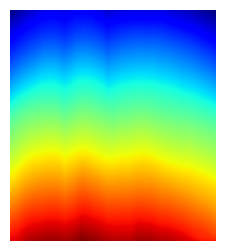

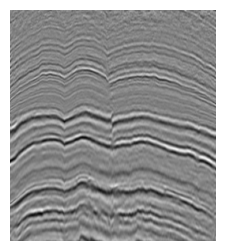

In [46]:
train_sample = train_data[20]
print(f"train_sample: {train_sample.keys()}")
image = train_sample['image'][0]
masks = train_sample['masks'][0]
attrs = train_sample['attrs'][0]
labels = train_sample['labels'][0]

draw.draw_img(masks[0], figsize=(3,3), origin='upper', cmap='jet')
draw.draw_img(attrs, figsize=(3,3), origin='upper', cmap='jet')
draw.draw_img(image, figsize=(3,3), origin='upper', cmap='gray')

### Training CNN

In [47]:
train_data =  utils.build_dataset_regression(param, samples_train, mode='Train', norm='mea_std')
valid_data =  utils.build_dataset_regression(param, samples_valid, mode='Valid', norm='mea_std')

In [48]:
# 定义网络
model = getattr(models, param['model_name'])(param)
loss_name = '+'.join([f"{'{:.3f}'.format(value)}*{key}" for key, value in param['loss_type'].items()])    

Loading Checkpoint: segment_anything/checkpoints/sam_vit_b_01ec64.pth ...


In [49]:
# 并行模式
if num_GPU > 1:
    print(f"多核模式")
    model = torch.nn.DataParallel(model, device_ids=range(num_GPU)).to(device)
else:
    print(f"单核模式")  
model = model.to(device)

单核模式


In [50]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_trainable_parameters(model)
print(f"Trainable parameters: {num_params:,}")

Trainable parameters: 86,441,778


In [53]:
# 模型保存路径   
if param['model_name'] in ['SDSAM']:
    task_name = param['encoder_type']
    model_name = '-'.join([param['model_name'], param['model_type']])
else:
    model_name = param['model_name']
    task_name = model_name
    
task_name = param['encoder_type']
if param['encoder_type'] == 'vit':
    task_name = '_'.join([task_name, param['transfer']])
    if param['transfer'] == "lora":
        task_name = task_name + str(param['num_lora'])
        
session_name = '-'.join([
    model_name, 
    "dataset_"+dataset_name, 
    task_name.lower(),
])                                     
            
checkpoint_path = os.path.join('result', session_name)
param['checkpoint_path'] = checkpoint_path    
param['use_checkpoint'] = True
print(f"模型读取路径: {checkpoint_path}")

模型读取路径: result/SDSAM-vit_b-dataset_seismic_inversion_tpd-regression-6120-vit_lora1


In [ ]:
# 训练网络
utils.train_valid_net(param, model, train_data, valid_data=valid_data, device=device)

=> Loaded checkpoint 'result/SDSAM-vit_b-dataset_seismic_inversion_tpd-regression-6120-vit_lora1/checkpoint-latest.pth' (epoch 140)


### Inference

In [12]:
# 载入模型
checkpoint_file = [x for x in os.listdir(checkpoint_path) if x.endswith('checkpoint-best.pth')][0]
print(f"checkpoint_file: {checkpoint_file}")
model.load_state_dict(torch.load(os.path.join(checkpoint_path, checkpoint_file))['state_dict'])

checkpoint_file: epoch=283_checkpoint-best.pth


<All keys matched successfully>

In [13]:
samples_valid = dataset.read_json(os.path.join(dataset_path, 'samples_valid.json'))
valid_data =  utils.build_dataset_regression(param, samples_valid, mode='Valid', norm=None)

In [17]:
valid_well_names = ['L_9', 'L_15', 'L_20', 'L_23']
apply_func = apply.Valid(param, model, device='cuda')
collect_outputs = apply_func.apply(valid_data)

collect_output0: dict_keys(['image', 'UID', 'original_size', 'masks', 'labels', 'weights', 'attrs', 'pred_probs'])
key[image]: (1, 401, 357)
key[UID]: (1,)
key[original_size]: (2,)
key[masks]: (1, 401, 357)
key[labels]: (1, 1)
key[weights]: (1, 1, 401, 357)
key[attrs]: (1, 401, 357)
key[pred_probs]: (1, 401, 357)
Valid well incldued: dict_keys(['L_23'])


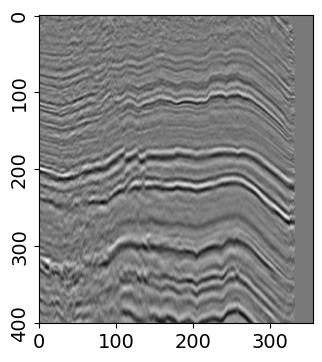

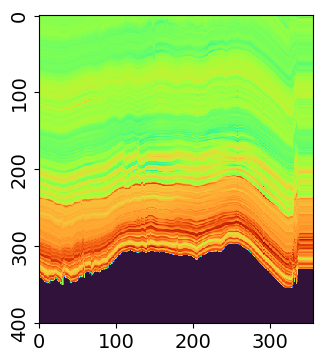

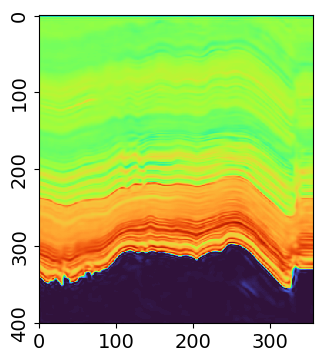

In [18]:
k = 50
collect_output0 = collect_outputs[k]
image = collect_output0['image'][0].copy()
masks = collect_output0['masks'][0].copy()
labels = collect_output0['labels'][0].copy()
pred_probs = collect_output0['pred_probs'][0].copy()

zeros = np.ones_like(image)
zeros[masks <= 0.] = 0.

figsize = (4,4)
draw.draw_img(image, figsize=figsize, origin='upper',
              cmap='gray', axis_off=False)
draw.draw_img(masks * zeros, figsize=figsize, origin='upper',
              interpolation='nearest',
              cmap='turbo', cmin=masks.min(), cmax=masks.max(),
         axis_off=False)
draw.draw_img(pred_probs, figsize=figsize, origin='upper',
              interpolation='nearest',
              cmap='turbo', cmin=masks.min(), cmax=masks.max(),
         axis_off=False)

raw_data_dict = valid_data.get(collect_output0['UID'])
well_match = apply.extract_well_match(raw_data_dict, pred_probs, valid_well_names)
print(f"Valid well incldued: {well_match.keys()}")

for key in well_match.keys():
    well_trace_tgt, well_trace_pred = well_match[key]

In [92]:
metric_path = os.path.join('metric')
sorted([x for x in os.listdir(metric_path) if x.endswith('.npy')])
model_list = ['Target', 'Drn', 'Resnet', 'Lora1', 'Lora2', 'Prompt', 'Refine', 'Scratch', 'Mobilenet', 'Efficientnet']
model_labels = ['Target', 'Drn', 'Resnet', 'FM-Lora1', 'FM-Lora2', 'FM-Prompt', 
              'FM-Finetune', 'FM-Scratch', 'Mobilenet', 'Efficientnet']
well_names = ['L_9', 'L_15', 'L_20', 'L_23']

In [136]:
well_name = well_names[1]
print(f"well_name: {well_name}")
results = []
for model_name in model_list:
    file_name = f"{model_name}-{well_name}.npy"
    result = np.load(os.path.join(metric_path, file_name), allow_pickle=True)
    results.append(result)

well_name: L_15


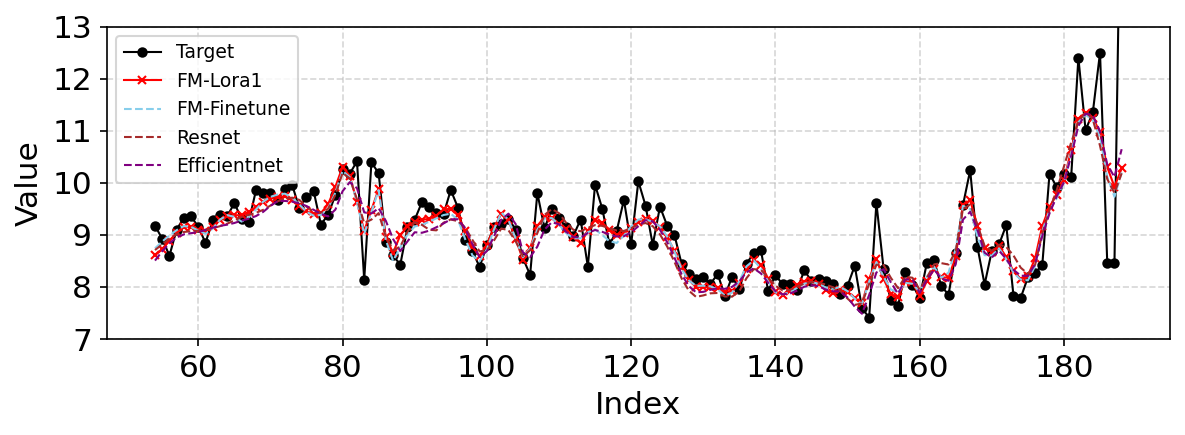

In [148]:
js = [0,3,6,2,9]
draw.plot_validation_log1(
    results[js[0]], 
    results[js[1]], 
    results[js[2]], 
    results[js[3]], 
    results[js[4]], 
    labels = [model_labels[j] for j in js],
    ylim=[7.0, 13], # L_15
    ynumticks=6,
    # ylim=[6.0, 12.178237998485566], # L_20
    show_label = True,
    fontsize=15,
    labelsize=9,
    figsize=(8,3))

In [111]:
regress_metrics = apply.RegressionMetrics()
num_sample = len(collect_outputs)
metrics_avg = dict()
for j in range(num_sample):
    collect_output0 = collect_outputs[j]
    masks = collect_output0['masks']
    pred_probs = collect_output0['pred_probs'] 
    pred_probs[masks<=0.] = masks[masks<=0.]
    metrics = regress_metrics(pred_probs, masks)
    if j == 0:
        for key in metrics.keys(): 
            metrics_avg[key] = metrics[key] / num_sample
    else:
        for key in metrics.keys(): 
            metrics_avg[key] += metrics[key] / num_sample
            
pprint(metrics_avg)

{'mae': tensor(0.1789),
 'mse': tensor(0.2213),
 'psnr': tensor(26.5763),
 'rmse': tensor(0.4591),
 'ssim': tensor(0.7614)}
